# Data Science template - Titanic Case

Deze notebook begeleidt je stap voor stap door de **Titanic**-case op Kaggle.
De focus ligt op de standaard Data Science workflow:

1. Probleemdefinitie en doel
2. Data-input & Data cleaning
3. Verkenning (EDA)
4. Feature engineering
5. Modelleren (baseline → verbeterde modellen)
6. **Voorspelling** en export van `submission.csv`

> 🎯 Doel: voorspel de kans dat een passagier de Titanic-vaart heeft overleefd (`Survived`).

## 0. Doel & Omgevings-setup

- Download `train.csv` en `test.csv` handmatig van de Titanic-competitiepagina en plaats ze in een bijvoorbeeld in dezelfde map als dit bestand.


In [1]:
# !python --version


## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Probleemdefinitie

- **Input**: passagiersgegevens zoals `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, etc.
- **Output**: binaire target `Survived` (0 = niet overleefd, 1 = overleefd).
- **Metric (Kaggle leaderboard)**: **Accuracy** op de testset (zonder labels).


## 3. Data inladen

In [3]:
# Je gaat werken met de train data. In de test data staan de Survived kolom niet ingevuld. Deze moet je dus zelf voorspellen.

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## 4. Snelle datacheck & Preprocessing

Waar missen we (rijen met) data? Je kan missende data invullen door bijvoorbeeld voor bepaalde soort data op een bepaalde manier in te vullen:

- Numeriek: imputatie (median) + scaling
- Categorisch: imputatie (most_frequent) + one-hot encoding

In [4]:
# Bereken gemiddelde en standaarddeviatie van bestaande leeftijden
mean_age = train["Age"].mean()
std_age = train["Age"].std()

# vul missende leeftijden in met normale verdeling en clamp tussen 0 en 81
train["Age"] = train["Age"].apply(
    lambda x: int(np.clip(np.random.normal(mean_age, std_age), 0, 81)) if pd.isna(x) else x
)

# bereken gemiddelde en standaarddeviatie van bestaande leeftijden
mean_age = test["Age"].mean()
std_age = test["Age"].std()

# vul missende leeftijden in met normale verdeling en clamp tussen 0 en 81
test["Age"] = test["Age"].apply(
    lambda x: int(np.clip(np.random.normal(mean_age, std_age), 0, 81)) if pd.isna(x) else x
)


# maak een dictionaries van Sex en Embarked
dict_Embarked = {'S':0, 'C':1, 'Q':2} 
dict_Sex = {"male": 0, "female": 1}
dict_Pclass = {1:0, 2:1, 3:2}

# drop Nan waarders in kolom Embarked
train = train.dropna(subset=['Embarked'])
test = test.dropna(subset=['Embarked'])

# maak nieuwe kolommen voor sex en Embarked voor train data
train['Embarked_int'] = train['Embarked'].map(dict_Embarked)
train["Sex_int"] = train["Sex"].map(dict_Sex)
train['Pclass_0'] = train['Pclass'].map(dict_Pclass)

test['Embarked_int'] = test['Embarked'].map(dict_Embarked)
test["Sex_int"] = test["Sex"].map(dict_Sex)
test['Pclass_0'] = test['Pclass'].map(dict_Pclass)

# maak PassengerId kolom de index
test = test.set_index('PassengerId')
train = train.set_index('PassengerId')


# maak globale survival rate
survival_rate = train['Survived'].value_counts(normalize=True)[1]

# maak rijen voor de survival_rates_lookup met specefieke bins
def make_survivle_table(col, bins):
    bins = pd.cut(train[col], bins=bins, right=False)
    counts = bins.value_counts().sort_index()
    probs  = train.groupby(bins, observed=True)['Survived'].mean().reindex(counts.index)
    probs = probs.fillna(survival_rate)

    temp_df = pd.DataFrame({
      'bin': counts.index,
      'prob': probs.values,
      'count': counts.values
    }, index=[col]*len(counts))

    return temp_df

# maak rijen voor de survival_rates_lookup met quantitatieve bins (gelijke verdeling voor de bins)
def qmake_survivle_table(col, q):
    bins = pd.qcut(train[col], q=q, duplicates='drop')

    counts = bins.value_counts().sort_index()
    probs  = train.groupby(bins, observed=True)['Survived'].mean().reindex(counts.index)
    probs = probs.fillna(survival_rate)

    temp_df = pd.DataFrame({
        'bin': counts.index,
        'prob': probs.values,
        'count': counts.values
    }, index=[col]*len(counts))

    return temp_df


bSurvival_rates_lookup = pd.DataFrame() # maak lege dataframe

# maak rijen voor de features
qAge_bins_n = qmake_survivle_table('Age', 10)
qFare_bins_n = qmake_survivle_table('Fare', 25)
qSex_bins_n = make_survivle_table('Sex_int', range(0, 3, 1))
qSibSp_bins_n = make_survivle_table('SibSp', range(0, 8, 1))
qParch_bins_n = make_survivle_table('Parch', range(0, 8, 1))
qEmbarked_bins_n = make_survivle_table('Embarked_int', range(0, 4, 1))
qPclass_bins_n = make_survivle_table('Pclass_0', range(0, 4, 1))

# voeg feature rows toe aan de lege tabel
qSurvival_rates_lookup = pd.concat([bSurvival_rates_lookup,
                                    qAge_bins_n, 
                                    qFare_bins_n,
                                    qSex_bins_n,
                                    qSibSp_bins_n,
                                    qParch_bins_n,
                                    qEmbarked_bins_n,
                                    qPclass_bins_n])


## 5. Verkennende Data Analyse (EDA)

> Tip: Voeg hier extra grafieken toe (bijv. histogrammen, boxplots, countplots per feature).


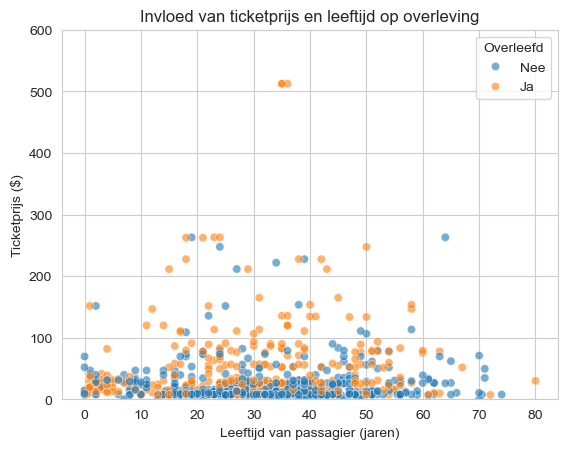

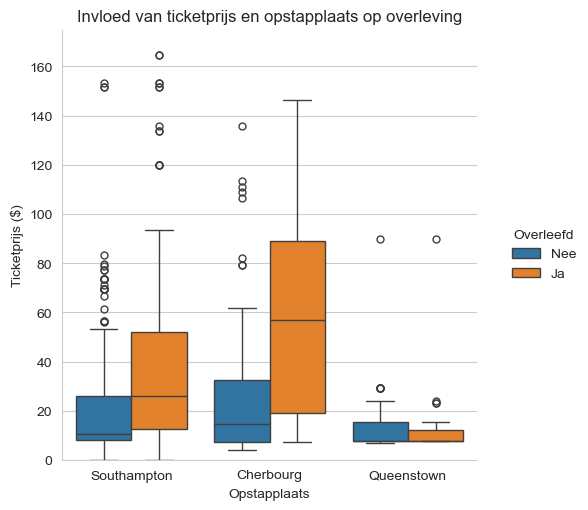

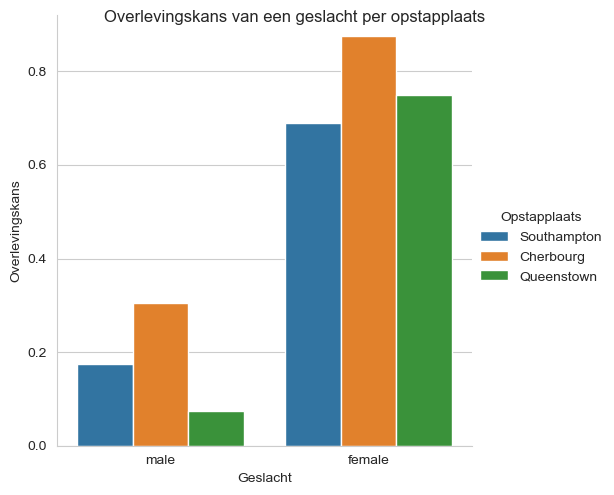

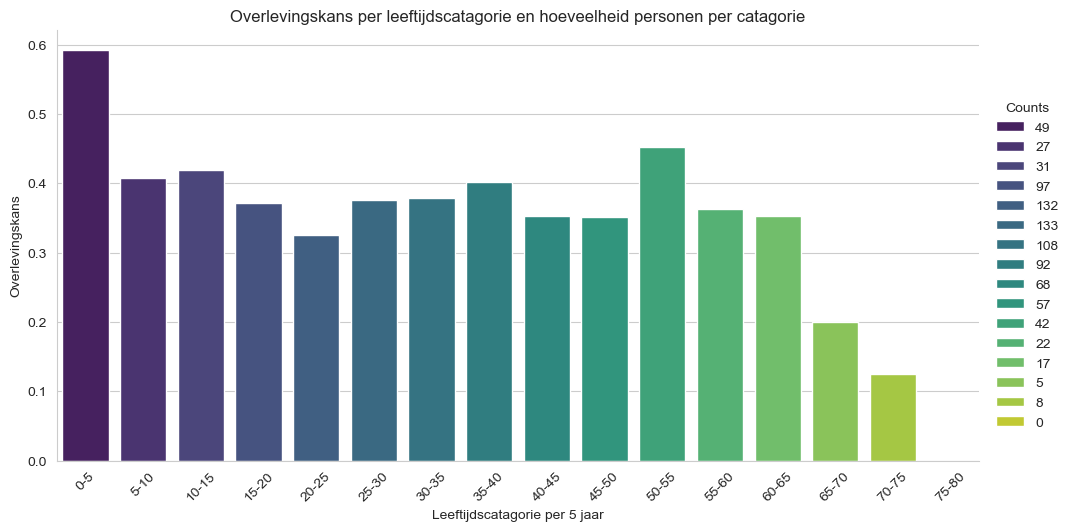

In [5]:
plt.clf()  # haalt probleem weg, verwijder niet

palette = {"Nee": "red", "Ja": "green"}
train["Survived_label"] = train["Survived"].map({0: "Nee", 1: "Ja"})
sns.set_style('whitegrid')


# PLOT 1 
graph = sns.scatterplot(
    data=train.dropna(subset=["Embarked","Age"]),
    x="Age",
    y="Fare",
    hue="Survived_label",
    alpha=0.6,
)

plt.title("Invloed van ticketprijs en leeftijd op overleving")
plt.xlabel("Leeftijd van passagier (jaren)")
plt.ylabel("Ticketprijs ($)")
plt.legend(title="Overleefd")
plt.ylim(0, 600)

plt.show()
 
 

'''
Conclusie scatterplot:
- Mensen die goedkope tickets kochten overleefde het vaak niet.
- Veel doden tussen de 20 en 70 jaar; veel mensen zaten in deze leeftijdsrange
- opvallend veel jonge kinderen overleefde de ramp
'''

train["Embarked_full"] = train["Embarked"].map({"C":"Cherbourg", "Q":"Queenstown", "S": "Southampton"})
# PLOT 2
g = sns.catplot(x='Embarked_full', y='Fare', hue='Survived_label', data=train, kind='box')
g.set(ylabel='Ticketprijs ($)',
        xlabel='Opstapplaats',
        title='Invloed van ticketprijs en opstapplaats op overleving')
g._legend.set_title("Overleefd")
#g.set_title('test')
plt.ylim(0, 175)
plt.show()

# PLOT 3
g = sns.catplot(
    x='Sex', y='Survived', 
    data=train, kind='bar', 
    hue='Embarked_full', 
    errorbar=None
)
g.fig.suptitle('Overlevingskans van een geslacht per opstapplaats')
g._legend.set_title("Opstapplaats")
g.set(ylabel='Overlevingskans',
      xlabel='Geslacht')
plt.show()


# PLOT 4
# Bin ages
train["Age_bin"] = pd.cut(train["Age"], bins=range(0, 85, 5), right=False)
train["Age_bin_label"] = train["Age_bin"].apply(lambda x: f"{int(x.left)}-{int(x.right)}")

# Compute counts per bin
counts = train["Age_bin_label"].value_counts().to_dict()

# Add a hue column based on counts
train["Age_count"] = train["Age_bin_label"].map(counts)

# Plot with hue
g = sns.catplot(
    x="Age_bin_label", y="Survived",
    hue="Age_count",  # this adds color by number of passengers in the bin
    data=train, kind="bar",
    errorbar=None,
    height=5, aspect=2,
    palette="viridis"
)

g.set(
    ylabel="Overlevingskans",
    xlabel="Leeftijdscatagorie per 5 jaar",
    title='Overlevingskans per leeftijdscatagorie en hoeveelheid personen per catagorie'
)
g._legend.set_title("Counts")
plt.xticks(rotation=45)
plt.show()


## 6. Feature Engineering

Voeg hier zelf extra features toe (bijv. `Title` uit `Name`, `FamilySize = SibSp + Parch + 1`, indicatoren, etc.).

Zorg wel dat het relevant is voor je eigen onderzoek. Waar ligt je eigen focus.

In [6]:
# Je kan nu zelf features aanmaken invullen. 
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

print(train['FamilySize'])
FS_n = pd.crosstab(train['FamilySize'], train['Survived'], normalize='index')


''' 
# maak een dictionaries van Sex en Embarked
dict_Embarked = {'S':0, 'C':1, 'Q':2} 
dict_Sex = {"male": 0, "female": 1}
dict_Pclass = {1:0, 2:1, 3:2}

# drop missing values of column 'Embarked'
train = train.dropna(subset=['Embarked'])

# maak nieuwe kolommen voor sex en Embarked
train['Embarked_int'] = train['Embarked'].map(dict_Embarked)
train["Sex_int"] = train["Sex"].map(dict_Sex)
train['Pclass_0'] = train['Pclass'].map(dict_Pclass)

train = train.dropna(subset=['Embarked'])
'''

PassengerId
1      2
2      2
3      1
4      2
5      1
      ..
887    1
888    1
889    4
890    1
891    1
Name: FamilySize, Length: 889, dtype: int64


' \n# maak een dictionaries van Sex en Embarked\ndict_Embarked = {\'S\':0, \'C\':1, \'Q\':2} \ndict_Sex = {"male": 0, "female": 1}\ndict_Pclass = {1:0, 2:1, 3:2}\n\n# drop missing values of column \'Embarked\'\ntrain = train.dropna(subset=[\'Embarked\'])\n\n# maak nieuwe kolommen voor sex en Embarked\ntrain[\'Embarked_int\'] = train[\'Embarked\'].map(dict_Embarked)\ntrain["Sex_int"] = train["Sex"].map(dict_Sex)\ntrain[\'Pclass_0\'] = train[\'Pclass\'].map(dict_Pclass)\n\ntrain = train.dropna(subset=[\'Embarked\'])\n'

## 7. Baseline model — np.where invullen

In [7]:
# zoek overlevingspercentage die hoort bij invoer
def lookup_probability(index, value):
    feature_rows = qSurvival_rates_lookup.loc[index]
    row = feature_rows[feature_rows['bin'].apply(lambda x: value in x)]

    if not row.empty:
        if row['prob'].iloc[0] <= 1e-2:  # als overlevingskans klein is maak .01 (1%)
            return 1e-2
        else:
            return row['prob'].iloc[0]
    else:
        return survival_rate


In [8]:
# definieer weights voor features
Age_weight = .7
Fare_weight = 0.2
Sex_weight = 1.5
SibSp_weight = 1
Parch_weight = 1.05
Emabrked_weight = 1
Class_weight = .0

# maak Dataframe aan voor de test data
SurvivalTest = pd.DataFrame(index=test.index)
SurvivalTest['pAge'] = test['Age'].apply(lambda v: lookup_probability('Age', v))
SurvivalTest['pFare'] = test['Fare'].apply(lambda v: lookup_probability('Fare', v))
SurvivalTest['pSex'] = test['Sex_int'].apply(lambda v: lookup_probability('Sex_int', v))
SurvivalTest['pSibSp'] = test['SibSp'].apply(lambda v: lookup_probability('SibSp', v)) 
SurvivalTest['pParch'] = test['Parch'].apply(lambda v: lookup_probability('Parch', v))
SurvivalTest['pEmbarked'] = test['Embarked_int'].apply(lambda v: lookup_probability('Embarked_int', v))
SurvivalTest['pPclass'] = test['Pclass_0'].apply(lambda v: lookup_probability('Pclass_0', v))

# maak kolom oon voor overlevingskans
SurvivalTest['pSurvive'] = (
    Age_weight *  np.log(SurvivalTest['pAge']) +
    Fare_weight * np.log(SurvivalTest['pFare']) +
    Sex_weight * np.log(SurvivalTest['pSex']) +
    SibSp_weight * np.log(SurvivalTest['pSibSp']) +
    Parch_weight * np.log(SurvivalTest['pParch']) +
    Emabrked_weight * np.log(SurvivalTest['pEmbarked']) +
    Class_weight * np.log(SurvivalTest['pPclass'])
)

# maak kolom aan voor sterf kans
SurvivalTest['pDie'] = (
    Age_weight * np.log(1 - SurvivalTest['pAge']) +
    Fare_weight * np.log(1 - SurvivalTest['pFare']) +
    Sex_weight * np.log(1 - SurvivalTest['pSex']) +
    SibSp_weight * np.log(1 - SurvivalTest['pSibSp']) +
    Parch_weight * np.log(1 - SurvivalTest['pParch']) +
    Emabrked_weight * np.log(1 - SurvivalTest['pEmbarked']) +
    Class_weight * np.log(1 - SurvivalTest['pPclass'])
)

# gebruik overleving en sterf kans om totale overlevingskans te maken
SurvivalTest['pTotal'] = np.exp(SurvivalTest['pSurvive'] - SurvivalTest['pDie']) / (1 + np.exp(SurvivalTest['pSurvive'] - SurvivalTest['pDie']))

# maak rank kolom gebaseerd op sorted totale overlevingskans
SurvivalTest['rank'] = SurvivalTest['pTotal'].rank(method='first', ascending=False)
n_survive = int(survival_rate * len(SurvivalTest))
threshold_rank = n_survive
# alles wat in de top 38% (survival_rate) zit, overleeft
SurvivalTest['Survived_pred'] = (SurvivalTest['rank'] <= threshold_rank).astype(int)

### USE ON TRAIN DATA
# genereer overlevingskans fouten enz, helemaal mooi
SurvivalTest['Survived_true'] = train['Survived']
SurvivalTest['Wrong'] = SurvivalTest['Survived_pred'] != SurvivalTest['Survived_true']
wrong_predictions = SurvivalTest[SurvivalTest['Survived_pred'] != SurvivalTest['Survived_true']]

pred_fraction = SurvivalTest['Survived_pred'].mean()

pred_survive_fraction = SurvivalTest['Survived_pred'].sum() / len(SurvivalTest)

# geef weer welke rijen fout zijn
SurvivalTest['Wrong'] = SurvivalTest['Survived_pred'] != SurvivalTest['Survived_true']

# tel hoeveel er fout zijn
num_wrong = SurvivalTest['Wrong'].sum()

wrong_predictions = SurvivalTest[SurvivalTest['Wrong']]

# tel hoeveel foute predictions overlevend of stervend waren (hoe dichter bij overlevend=stervend, hoe beter)
wrong_counts_by_true = wrong_predictions['Survived_true'].value_counts()

## 8. Maak een eindmodel op volledige trainingsdata en voorspel op test

Hier kiezen we als voorbeeld het np.where model (of gebruik anders een ander model).


In [9]:
submission = pd.DataFrame({ 
    'PassengerId' : SurvivalTest.index, 
    'Survived' : SurvivalTest['Survived_pred'] 
}).reset_index(drop=True)

submission.to_csv("submission.csv", index=False)
print("submission.csv aangemaakt!")
submission.head()


submission.csv aangemaakt!


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 9. Checklist & Volgende stappen

- [ ] Zorg dat er een duidelijke samenhang is tussen de grafieken -> Feature Engineering -> je uiteindelijke model! Dat is het belangrijkst.
- [ ] Laat geen grafieken zien waar je niks mee doet tijdens de presentatie.
- [ ] Zorg dat er dus een rode draad is in je verhaal. 

Voorbeeld: We hebben de focus gelegd op leeftijd -> EDA laat deze grafieken met leeftijd zien. We hebben met Feature Engineering nog leeftijdsgroepen aangemaakt -> We hebben in het model de leeftijden gebruikt. Dit is onze score.

- [ ] Eventueel EDA (een klein beetje) uitbreiden (meer grafieken, correlaties, outliers)
- [ ] Feature engineering verbeteren (wat is er relevant?)
- [ ] Meer modellen proberen (Logistic Regression? Sklearn)
- [ ] Submission inleveren op kaggle en kijken hoe goed je score is

Succes met de case!